**Downloads**

In [24]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # sometimes needed for lemmatizer
nltk.download('punkt_tab')  # resolves your specific error

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Libraries**

In [43]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import spacy
import matplotlib.pyplot as plt

**Mount Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load data set**

In [29]:
# Load the merged Apple news dataset
news_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Finance Projects/Sentiment-Analysis-on-Financial-News-and-Its-Impact-on-Stock-Prices/data/investing_com_apple_news.csv')

In [31]:
# Create a new column `text` by combining headline + summary (if available)
news_df["headline"] = news_df["headline"].fillna("")
news_df["summary"] = news_df["summary"].fillna("")
news_df["text"] = news_df["headline"] + ". " + news_df["summary"]

In [32]:
news_df.head()

,date,headline,summary,url,source,text
0,2025-07-21 18:55:59,"S&P 500 and Nasdaq hit record highs, lifted by...",By Noel Randewich and Nikhil Sharma (Reuters) ...,https://www.investing.com/news/stock-market-ne...,Investing.com,"S&P 500 and Nasdaq hit record highs, lifted by..."
1,2025-07-21 14:15:42,"Morgan Stanley upgrades Pinterest, sees AWS an...",Investing.com -- Morgan Stanley raised estimat...,https://www.investing.com/news/stock-market-ne...,Investing.com,"Morgan Stanley upgrades Pinterest, sees AWS an..."
2,2025-07-21 12:48:24,DoJ to announce USA vs. GOOGL remedies any day...,Investing.com -- The U.S. Department of Justic...,https://www.investing.com/news/stock-market-ne...,Investing.com,DoJ to announce USA vs. GOOGL remedies any day...
3,2025-07-19 10:21:49,5 big analyst AI moves: Microsoft PT hike; Tes...,Investing.com -- Here are the biggest analyst ...,https://www.investing.com/news/stock-market-ne...,Investing.com,5 big analyst AI moves: Microsoft PT hike; Tes...
4,2025-07-19 03:31:02,Bernstein’s 15 top Asia stocks for 2H25,,https://www.investing.com/news/pro/bernsteins-...,Investing.com,Bernstein’s 15 top Asia stocks for 2H25.


**Pre-processing**

In [33]:
# Preprocessing functions

#  Define text cleaner
def clean_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove numbers and special characters
    text = re.sub(r"[^a-zA-Z\s]", '', text)

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

#  Apply text cleaner
news_df["cleaned_text"] = news_df["text"].apply(clean_text)

#  Drop rows where cleaned_text is empty or NaN
news_df = news_df[news_df["cleaned_text"].notna()]
news_df = news_df[news_df["cleaned_text"].str.strip() != ""]
news_df.reset_index(drop=True, inplace=True)

**Save**

In [34]:
# Save cleaned file
clean_path = "/content/drive/MyDrive/Colab Notebooks/Finance Projects/Sentiment-Analysis-on-Financial-News-and-Its-Impact-on-Stock-Prices/data/apple_sentiment_dataset.csv"
news_df.to_csv(clean_path, index=False)

# Final check
print(" Final cleaned shape:", news_df.shape)
print(" Sample cleaned row:\n", news_df[["date", "headline", "cleaned_text"]].head(3))

 Final cleaned shape: (1503, 7)
 Sample cleaned row:
                   date                                           headline  \
0  2025-07-21 18:55:59  S&P 500 and Nasdaq hit record highs, lifted by...   
1  2025-07-21 14:15:42  Morgan Stanley upgrades Pinterest, sees AWS an...   
2  2025-07-21 12:48:24  DoJ to announce USA vs. GOOGL remedies any day...   

                                        cleaned_text  
0  sp nasdaq hit record high lifted alphabet noel...  
1  morgan stanley upgrade pinterest see aws genai...  
2  doj announce usa v googl remedy day here expec...  


**Plots & Insights**

**1. Word Cloud**

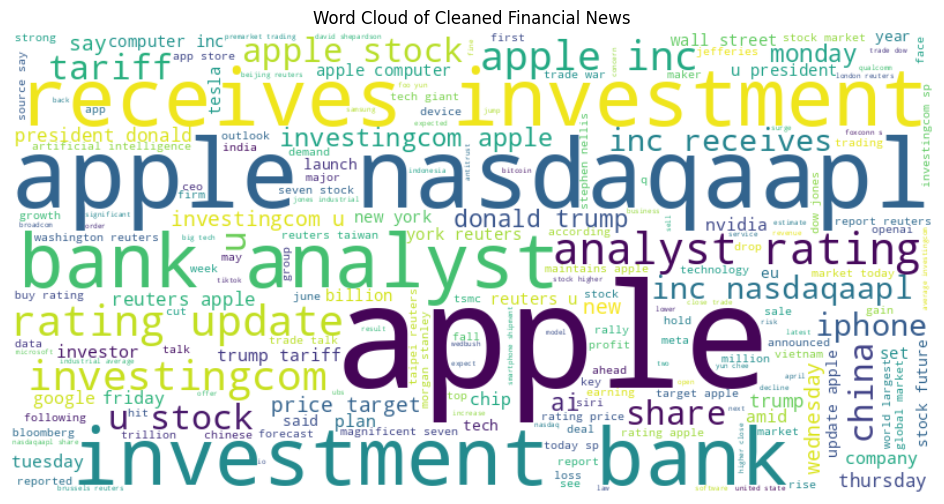

In [39]:
# Shows most frequent words
all_words = " ".join(news_df["cleaned_text"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Cleaned Financial News")
plt.show()

**2. Article Length Distribution (Word Count)**

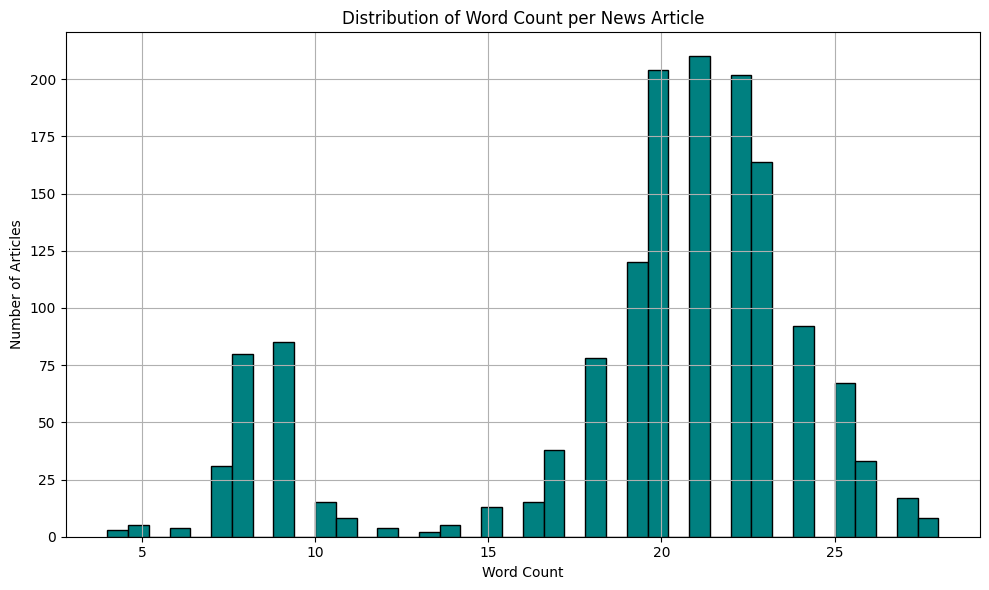

In [46]:
# Measures depth/detail of articles — longer articles might carry stronger sentiment signals.

news_df["word_count"] = news_df["cleaned_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(news_df["word_count"], bins=40, color='teal', edgecolor='black')
plt.title("Distribution of Word Count per News Article")
plt.xlabel("Word Count")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()


**3. Top N Frequent Words**

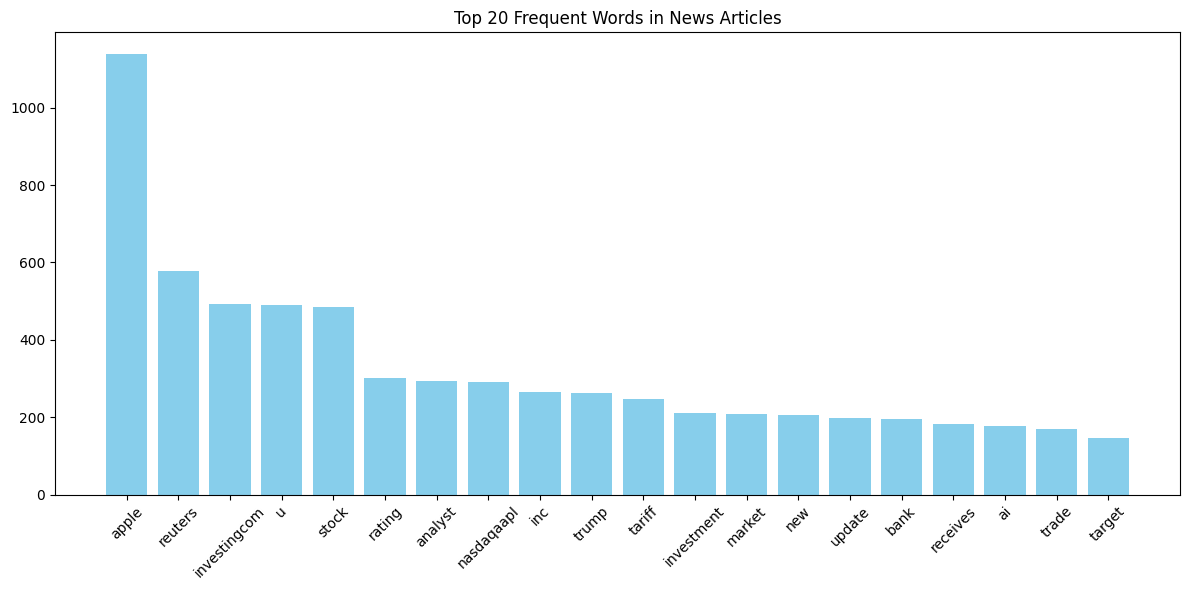

In [40]:
words = " ".join(news_df["cleaned_text"]).split()
top_words = Counter(words).most_common(20)

words_df = pd.DataFrame(top_words, columns=["Word", "Frequency"])

plt.figure(figsize=(12, 6))
plt.bar(words_df["Word"], words_df["Frequency"], color="skyblue")
plt.xticks(rotation=45)
plt.title("Top 20 Frequent Words in News Articles")
plt.tight_layout()
plt.show()

**4. News Volume Over Time**

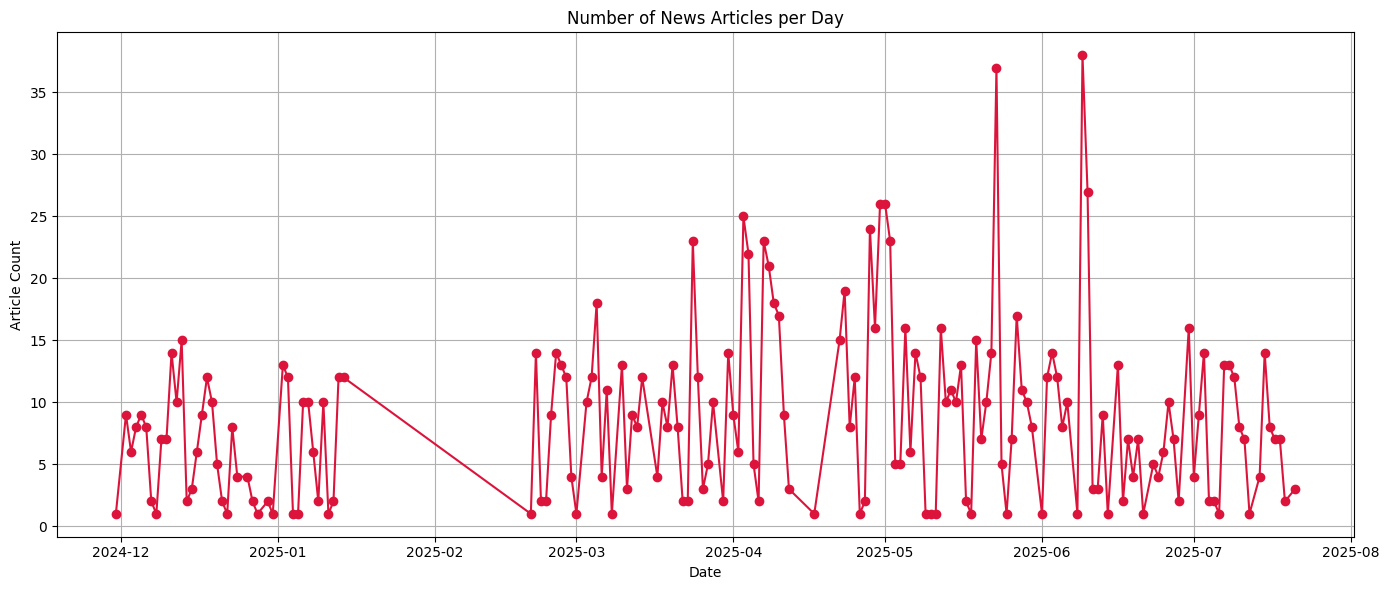

In [41]:
# News Volume Over Time
news_df["date"] = pd.to_datetime(news_df["date"])
daily_counts = news_df.groupby(news_df["date"].dt.date).size()

plt.figure(figsize=(14, 6))
daily_counts.plot(kind='line', marker='o', color='crimson')
plt.title("Number of News Articles per Day")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.grid(True)
plt.tight_layout()
plt.show()

**5. Weekly/Monthly News Heatmap**

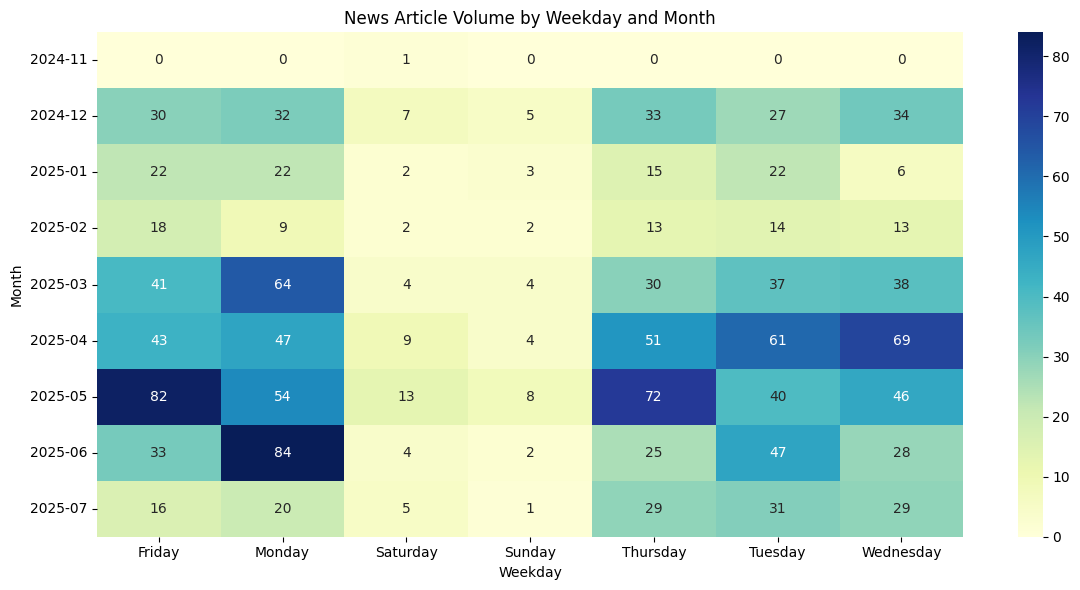

In [42]:
# When is Apple most talked about?

# Extract weekday and date
news_df["weekday"] = news_df["date"].dt.day_name()
news_df["month"] = news_df["date"].dt.to_period("M")

# Pivot table for heatmap
heatmap_data = news_df.groupby(["month", "weekday"]).size().unstack(fill_value=0)

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("News Article Volume by Weekday and Month")
plt.xlabel("Weekday")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

**6. Top Financial Entities or Keywords**

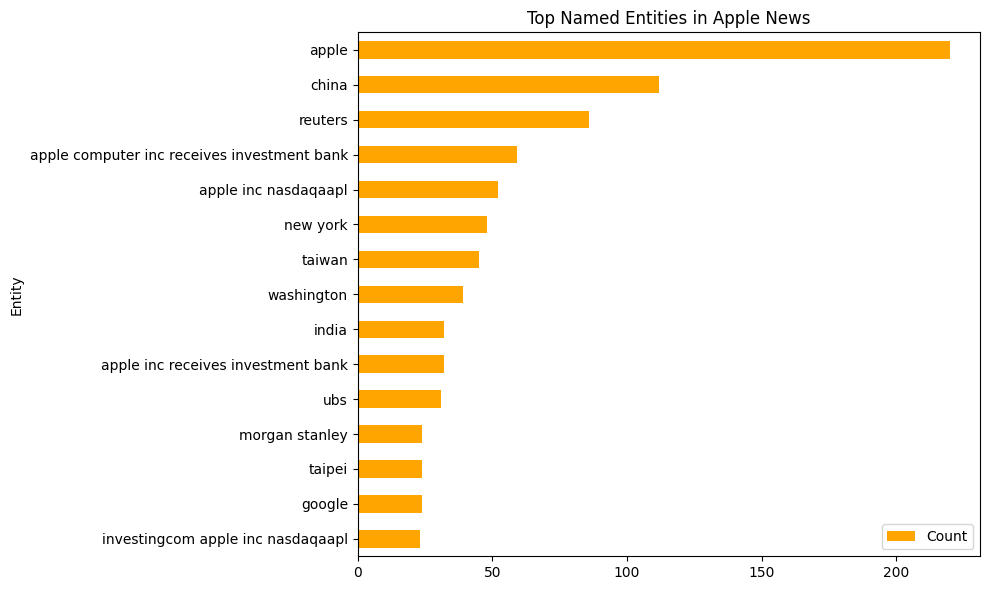

In [45]:
# extract top named entities (companies, policies, sectors) using spaCy

nlp = spacy.load("en_core_web_sm")
docs = list(nlp.pipe(news_df["cleaned_text"]))

# Extract top named entities (ORG, GPE, etc.)
entities = []
for doc in docs:
    entities.extend([ent.text for ent in doc.ents if ent.label_ in ["ORG", "GPE"]])

top_entities = Counter(entities).most_common(15)

# Plot
ent_df = pd.DataFrame(top_entities, columns=["Entity", "Count"])
ent_df.plot(kind="barh", x="Entity", y="Count", figsize=(10, 6), color="orange")
plt.title("Top Named Entities in Apple News")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()